In [1]:
import pickle
import numpy as np
import PIL.Image
import itertools
from IPython.core.display import Image, display
import scipy.ndimage
import random
import numpy as np
import matplotlib.pylab as plt
import tqdm
import math

# Сказали, что это можно юзать:)
from sklearn.model_selection import train_test_split

%matplotlib inline

# Загружаем датасет

In [2]:
with open('./hw_1_train.pickle', 'rb') as f:
    train = pickle.load(f)

with open('C:/Users/Ponom/Desktop/hw_1_test_no_lables.pickle', 'rb') as f:
    test_no_lables = pickle.load(f)

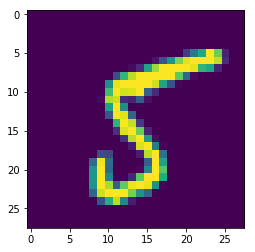

In [3]:
# Пример, как можно визуализировать данные
plt.imshow(train['data'][0].reshape(28,28))

# Этой функцией будем убирать ненужный вывод.
plt.show()

In [4]:
# Посмотрим, как должно выглядеть итоговое решение.

import pandas as pd
df = pd.read_csv('./sample_solution_random.csv')
df.head()

,Id,Prediction
0,0,0.298782
1,1,0.985304
2,2,0.974184
3,3,0.061595
4,4,0.604558


# Обучаем модель

In [5]:
# Переопределим метри классов на 0/1.
# Отметим, что это эквивалентно тому, что мы определим метки -1/1.
# Просто вычисление некоторых функций удет удобнее и приятнее:) Смысл от этого не меняется.

y_train = np.array([0 if int(i) == 5 else 1 for i in train['labels']])

In [6]:
# Нормализуем тренировочные данные.

mean = np.mean(train['data'], axis=0)
std = np.std(train['data'], axis=0)
X_train = (train['data'] - mean) / (std+0.0001)

In [7]:
# Нормализуем тестовые данные.

mean = np.mean(test_no_lables['data'], axis=0)
std = np.std(test_no_lables['data'], axis=0)
X_test_no_lables = (test_no_lables['data'] - mean) / (std+0.0001)

In [8]:
# Разделим изначальные тренировочные данные на данные для обучения и валидации.

x_train_spl, x_test_spl, y_train_spl, y_test_spl = train_test_split(X_train, y_train, random_state=11, test_size = 0.2)

In [9]:
def logit(x, w):
    return np.dot(x, w)

In [10]:
def sigmoid(h):
    return 1. / (1 + np.exp(-h))

In [11]:
class MyLogisticRegression(object):
    '''
    Простая логистическая регрессия для задачи бинарной классификации с градиентным спуском.
    '''
    
    def __init__(self, learning_rate=0.1, max_iter=300, tolerance=1e-15, lamb=0.01):
        self._lr = learning_rate
        
        self._max_iter = max_iter
        
        # Как часто будем запоминать изменения данных
        self._validation_freq = 10
        
        self._tolerance = tolerance
        
        # Параметр регуляризации
        self._lamb = lamb
        
        # Листы, по которым будут строиться графики
        self._tr_eval_loss = []
        self._te_eval_loss = []
        self._tr_eval_acc = []
        self._te_eval_acc = []
        
        
    def fit(self, X, y, X_test, y_test):
        # Добавляем дополнительный признак для w_0
        
        X = self.__add_intercept(X)
        n_objects, n_features = X.shape

        self._weights = np.random.normal(scale=0.001, size = n_features)
        
        # Градиентный спуск
        for i in range(self._max_iter):
            h = logit(X, self._weights)
            z = sigmoid(h)
            
            grad = np.dot(X.T, (z - y)) / len(y) + self._weights * self._lamb
            
            self._weights -= self._lr * grad
            
            if (np.linalg.norm(self._lr * grad) < self._tolerance):
                print("Сошлось за {} итераций!".format(i))
                break
            
            if i % self._validation_freq == 0:
                h = logit(X, self._weights)
                p = sigmoid(h)
                
                # Для стабильности вычислений
                p = np.clip(p, 1e-10, 1 - 1e-10)
                
                # Запоминаем данные для графиков
                self._tr_eval_loss.append(self.__loss(y, p))
                self._tr_eval_acc.append(np.mean((p >= 0.5) == y))
                self._te_eval_loss.append(self.__loss(y_test, self.predict_proba(X_test)))
                self._te_eval_acc.append(np.mean((self.predict(X_test) >= 0.5) == y_test))

        
    def predict(self, X, threshold=0.5):
        X = self.__add_intercept(X)
        
        return sigmoid(logit(X, self._weights)) >= threshold
    
    
    def predict_proba(self, X):
        X = self.__add_intercept(X)
        
        return sigmoid(logit(X, self._weights))
    
    
    def __add_intercept(self, X):
        return np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    
    
    def __loss(self, y, p):
        return np.mean(y * np.log(p) + (1 - y) * np.log(1 - p)) + self._lamb / 2 * (np.sum(self._weights ** 2))
    
    def draw(self):
        plt.title('Loss')
        plt.plot(self._tr_eval_loss, label='train')
        plt.plot(self._te_eval_loss, label='test')
        plt.xlabel('number of iteration $\cdot 10$')
        plt.legend()
        plt.show()
        
        plt.title('Acc')
        plt.plot(self._tr_eval_acc, label='train')
        plt.plot(self._te_eval_acc, label='test')
        plt.xlabel('number of iteration $\cdot 10$')
        plt.legend()
        plt.show() 
        
    def print_log_loss_and_acc(self):
        print(self._te_eval_loss[-1], self._te_eval_acc[-1])

In [12]:
clf = MyLogisticRegression(learning_rate=0.0675, max_iter=1600, lamb=0.001)

clf.fit(x_train_spl, y_train_spl, x_test_spl, y_test_spl)

# Оцениваем результат

Обязательно отрисуйте 2 графика:
- loss на обучающем и тестовом множесте
- % правильно классифицированных примеров на тестовом и обучающем множестве

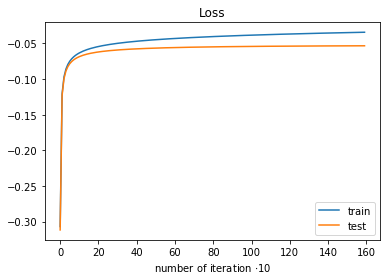

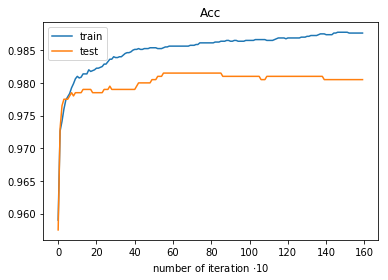

In [13]:
clf.draw()

# Сохраняем данные для кагла

https://www.kaggle.com/t/513ea517806348848dc78c4f41d44528

Результат записывается в простой текстовый файл. Первая строчка "Id,Prediction", далее для каждого примера из валидационного множества записывается его Id (порядковый номер, с нуля) и вероятность принадлежности к классу '6', например '123,0.12'.

Важно соблюдать тот же порядок следования элементов, что и в наборе данных. Нумерация id с 0

In [14]:
# Разделим изначальные тренировочные данные на данные для обучения и валидации.
# Обучим данные на большем количестве картинок))))

x_train_spl_kaggle, x_test_spl_kaggle, y_train_spl_kaggle, y_test_spl_kaggle = \
train_test_split(X_train, y_train, random_state=11, test_size = 0.001)

In [15]:
clf_kaggle = MyLogisticRegression(learning_rate=0.0675, max_iter=1600, lamb=0.001)

clf_kaggle.fit(x_train_spl_kaggle, y_train_spl_kaggle, x_test_spl_kaggle, y_test_spl_kaggle)

In [16]:
Y_pred = clf_kaggle.predict_proba(X_test_no_lables)

with open('solution.csv', 'w') as fout:
    print("Id,Prediction", file=fout)
    for i in range(len(X_test_no_lables)):
        print(i, Y_pred[i], sep=',', file=fout)

In [17]:
# Просмотрим то, что записали.

df2 = pd.read_csv('solution.csv')
df2.head()

,Id,Prediction
0,0,9.989882e-01
1,1,9.997545e-01
2,2,9.996064e-01
3,3,8.874373e-07
4,4,1.349449e-01


# Сдача

1. Регистрируетесь на конкурс https://www.kaggle.com/t/34e77301ef914c5792e4f4306144a6b3 
1. Преодолеваете "Pass level" baseline
1. После того, как вы преодолеете baseline, присылайте ноутбук с решение по адресу **voropaev@corp.mail.ru**

# Внимание
- Тему письма писать в формате "[МФТИ][1] Фамилия"
- Внутри писма прикрепляете файл ноутбука с именем <ваша фамилия>.ipynb